# Libraries and functions

In this section we import all the library that we are going to use in this project, we connect google colab to google drive and define all function that we are going to use multiple times during this work (function to run and evaluate models, as well as some functions for preprocessing)

In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import KFold, LeaveOneGroupOut, ShuffleSplit, train_test_split, GroupKFold
from sklearn.metrics import confusion_matrix, classification_report
import math
import os
from itertools import chain
from tqdm import tqdm
import seaborn as sns
from IPython.display import Audio

from scipy.signal import butter, lfilter
from sklearn.preprocessing import OneHotEncoder
import pickle
from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks
from scipy.signal import filtfilt

In [ ]:
np.random.seed(5)
tf.random.set_seed(5)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def run_model(model, x_train, y_train_ohe, x_test, y_test_ohe):
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss', restore_best_weights=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer)
  history=model.fit(x_train, y_train_ohe, batch_size=64, epochs=200, validation_data=(x_test, y_test_ohe), callbacks=early_stopping)
  return

In [ ]:
def plot_confusion_matrix(model, x_test, y_test_ohe):
  pred_test = model.predict(x_test)
  y_pred = encoder.inverse_transform(pred_test)

  y_test__ = encoder.inverse_transform(y_test_ohe)

  cm = confusion_matrix(y_test__, y_pred)
  plt.figure(figsize = (10, 8))
  cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
  sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
  plt.title('Confusion Matrix', size=25)
  plt.xlabel('Predicted Labels', size=15)
  plt.ylabel('Actual Labels', size=15)
  plt.show()

  #summary
  print(classification_report(y_test__, y_pred))
  return

# Original data and transformation

In this part we are going to look al the original data and see what happen applyng the transformation that we are going to use.

## Original audio

In [ ]:
file_name= 'rab-m1-n3.wav'
path = "drive/MyDrive/Project Human System Interfaces/EMOVO/" + "m1" + "/{}".format(file_name)
audio, sr = librosa.load(path, sr=None)
Audio(data=audio, rate=sr)

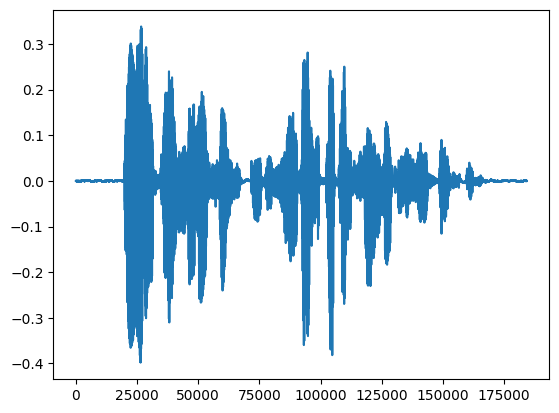

In [ ]:
plt.plot(range(len(audio)),audio)

## Features

The main features we are going to extract from the datas are the mel spectrogram and the mfcc (mel frequency cepstral cofficients), other options whold have been zero-crossing-rate and the root-mean-square

### Zero-crossing-rate

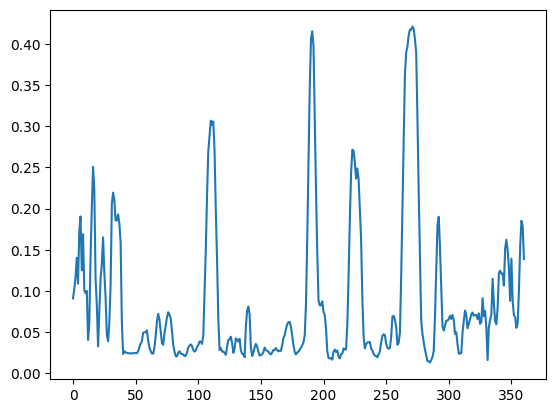

In [ ]:
zcr=librosa.feature.zero_crossing_rate(y=audio)[0]
plt.plot(range(len(zcr)), zcr)

### Root mean square

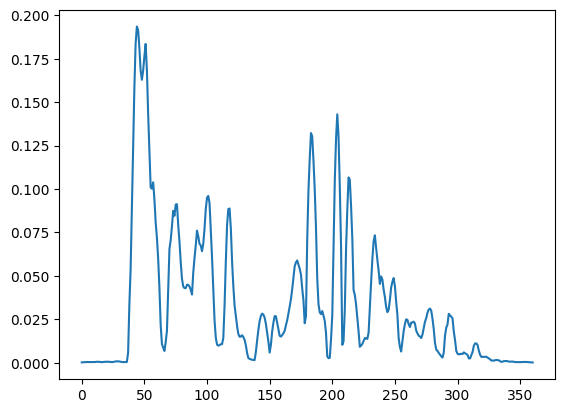

In [ ]:
rms=librosa.feature.rms(y=audio)[0]
plt.plot(range(len(rms)), rms)

### Mel spectrogram

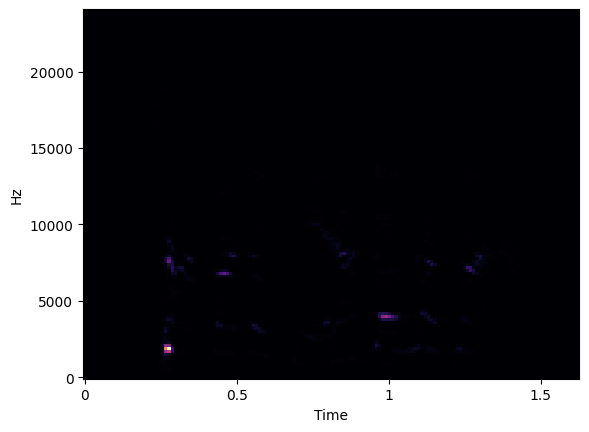

In [ ]:
mel=librosa.feature.melspectrogram(y=audio, sr=sr)
librosa.display.specshow(mel, sr=sr, x_axis='time', y_axis='hz')

### Mfcc

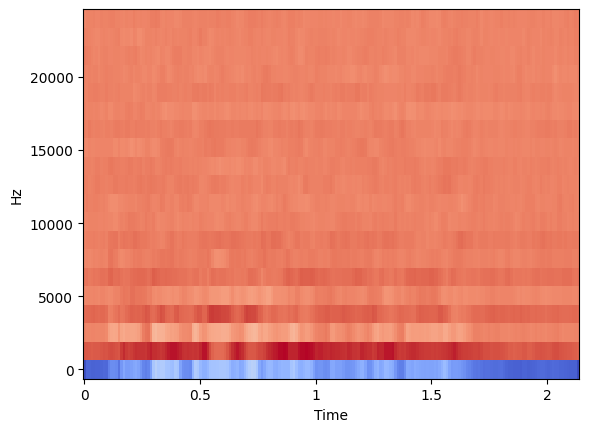

In [ ]:
mfcc=librosa.feature.mfcc(y=audio, sr=sr)
librosa.display.specshow(mfcc, sr=sr, x_axis='time', y_axis='hz')

### Chroma_stft

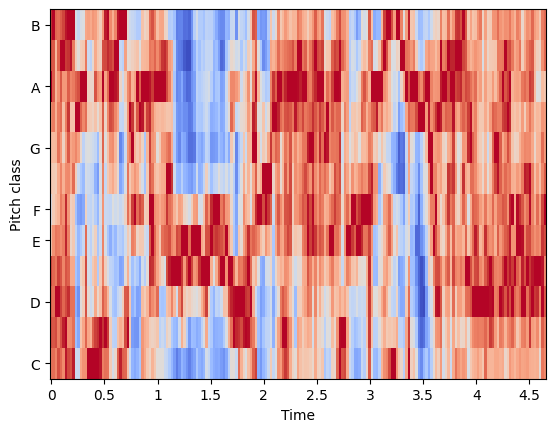

In [ ]:
stft = np.abs(librosa.stft(audio))
chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', cmap='coolwarm')

## Data augmentation

Later on in the code we are going to use data augmentation, we decided to apply 3 simple trasformasions: adding noise to the signal, stretching and pitching the signal, plus combination of them

In [ ]:
import scipy.io.wavfile as wav

In [ ]:
noise_amp = 0.035*np.random.uniform()*np.amax(audio)
audio2 = audio + noise_amp*np.random.normal(size=audio.shape[0])
Audio(audio2, rate=sr)
output_filename = "noise_audio.wav"
wav.write(output_filename, sr, audio2.astype(np.float32))

print(f"Modified audio saved to {output_filename}")

In [ ]:
audio3=librosa.effects.time_stretch(y=audio, rate=0.85)
Audio(audio3, rate=sr)
output_filename = "time_audio.wav"
wav.write(output_filename, sr, audio3.astype(np.float32))

print(f"Modified audio saved to {output_filename}")

Modified audio saved to time_audio.wav


In [ ]:
audio4=librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=0.5)
Audio(audio4, rate=sr)
output_filename = "pitch_audio.wav"
wav.write(output_filename, sr, audio4.astype(np.float32))

print(f"Modified audio saved to {output_filename}")

Modified audio saved to pitch_audio.wav


# Datasets

In this section we are going to create datasets that contain all information that we need in the following part, including the path for each audio and the ralative emotion

## Emovo

In [ ]:
#Definition of actors, emotions and phrases
actors=['m1', 'm2', 'm3', 'f1', 'f2', 'f3']
emotions=['tri', 'sor', 'rab', 'pau', 'neu', 'gio', 'dis']
phrases=['n1', 'n2', 'n3', 'n4', 'n5', 'l1', 'l2', 'l3', 'l4', 'd1', 'd2', 'b1', 'b2', 'b3']

df_len=len(actors)*len(emotions)*len(phrases)

file_emotion = []
file_path = []
file_act = []
file_phr = []

# to uniform the emotions with the ones of the other dataset
emo_dict={'tri': 'sad', 'sor': 'surprise', 'rab': 'angry', 'pau': 'fear', 'neu': 'neutral', 'gio': 'happy', 'dis': 'disgust'}

for act in actors:
  for emo in emotions:
    for phr in phrases:
      file_name=emo + '-' + act + '-' + phr + '.wav'
      path = "drive/MyDrive/Project Human System Interfaces/EMOVO/" + act + "/{}".format(file_name)

      file_emotion.append(emo_dict[emo])
      file_path.append(path)
      file_act.append(act)
      file_phr.append(phr)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
act_df = pd.DataFrame(file_act, columns=['Actor'])
phr_df = pd.DataFrame(file_phr, columns=['Phrase'])


# concatenation of different dataframes in a single one
Emovo_df = pd.concat([emotion_df, path_df, act_df, phr_df], axis=1)

# shuffling of dataframe
Emovo_df = Emovo_df.sample(frac = 1)

# displaying the head of the dataframe
Emovo_df.head()

,Emotions,Path,Actor,Phrase
505,surprise,drive/MyDrive/Project Human System Interfaces/...,f3,n2
349,fear,drive/MyDrive/Project Human System Interfaces/...,f1,b3
393,sad,drive/MyDrive/Project Human System Interfaces/...,f2,n2
300,sad,drive/MyDrive/Project Human System Interfaces/...,f1,l2
545,fear,drive/MyDrive/Project Human System Interfaces/...,f3,b3


## Ravdess

In [ ]:
#we have decided to use a different technique to load Ravdess files since the are stored in a different way

Ravdess = "drive/MyDrive/Project Human System Interfaces/RAVDESS/"
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')

        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,sad,drive/MyDrive/Project Human System Interfaces/...
1,sad,drive/MyDrive/Project Human System Interfaces/...
2,happy,drive/MyDrive/Project Human System Interfaces/...
3,angry,drive/MyDrive/Project Human System Interfaces/...
4,happy,drive/MyDrive/Project Human System Interfaces/...


## Crema D

In [ ]:
CremaD= "drive/MyDrive/Project Human System Interfaces/CREMAD/"
crema_directory_list = os.listdir(CremaD)

file_emotion = []
file_path = []

for file in crema_directory_list:
  file_path.append(CremaD + file)
  part=file.split('_')
  file_emotion.append(part[2])

path_df = pd.DataFrame(file_path, columns=['Path'])
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.Emotions.replace({'NEU':'neutral', 'HAP':'happy', 'SAD':'sad', 'ANG':'angry', 'FEA':'fear', 'DIS':'disgust'}, inplace=True)
Crema_df.head()

,Emotions,Path
0,fear,drive/MyDrive/Project Human System Interfaces/...
1,disgust,drive/MyDrive/Project Human System Interfaces/...
2,fear,drive/MyDrive/Project Human System Interfaces/...
3,angry,drive/MyDrive/Project Human System Interfaces/...
4,angry,drive/MyDrive/Project Human System Interfaces/...


# Preprocessing and feature extraction

## Function to perform preprocessing and feature extraction

Here we made the code to extract the features:
We decided to split our signal into windows of 2 seconds, then for each window we compute the chroma_stft, the mfcc and the mel spectrogram, after that we compute the mean over columns of each of the 3 computed matrixes, and at the end we concatenate the features obtaining a vector of length 160

In [ ]:
window_length=2 #length in seconds

In [ ]:
def extract_feature(data, SR):

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=SR), axis=1)

    mfcc = np.mean(librosa.feature.mfcc(y=data), axis=1)

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=SR), axis=1)

    features=np.concatenate([chroma_stft, mfcc, mel])

    return np.array(features)

## Application of the function and segmentation

Here we use the function we have previously defined on Emovo dataset.
Each audio is divided on windows of 2 seconds without overlapping

In [ ]:
features = []
emotions = []
actors = []
phrases = []

for i in range(Emovo_df.shape[0]):
    path=Emovo_df['Path'][i]
    data, sr = librosa.load(path)


    for j in range(math.floor(len(data)/(sr*window_length))):
      feature=extract_feature(data[window_length*sr*j:window_length*sr*(j+1)], sr)
      if feature.shape == (160,): #with this line we exclude windows that are shorter than 2 seconds (e.g. when the audio last 3 seconds we have the second windows that is shorter and must be discarded)
        features.append(feature)
        emotions.append(Emovo_df['Emotions'][i])
        actors.append(Emovo_df['Actor'][i])
        phrases.append(Emovo_df['Phrase'][i])

Then we save the preprocessed arrays to avoid running the previous section every time

In [ ]:
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/features.pickle', "wb") as fp:
  pickle.dump(features, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/actors.pickle', "wb") as fp:
  pickle.dump(actors, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/phrases.pickle', "wb") as fp:
  pickle.dump(phrases, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/emotions.pickle', "wb") as fp:
  pickle.dump(emotions, fp)

# Split into train and test set



In this section we split into train and test set and we apply the one hot encoder

In [ ]:
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/features.pickle', 'rb') as file:
    features = pickle.load(file)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/emotions.pickle', 'rb') as file:
    emotions = pickle.load(file)


In [ ]:
#split per Emovo
np.random.seed(1)
x_train, x_test, y_train, y_test = train_test_split(features, emotions, test_size= 0.3, random_state=0, shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.33, shuffle=True)


In [ ]:
#one hot encoder
encoder = OneHotEncoder()
y_train_ohe = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test_ohe = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()
y_val_ohe = encoder.fit_transform(np.array(y_val).reshape(-1,1)).toarray()

# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)


# Model

Here we define the model, is a CNN with convolution+maxpooling.

Please, note that the number of filter is increasing while the kernel size decrease as we go forward into the struture.

In total we have 5 convolutional + maxpooling block and 3 linear layers at the end. Dropout is used for regularization.

In [ ]:
#definition of the model
def cnn_for_ser_3(num_classes=7, print_summary=False):
  #input layer
  home_input = tf.keras.layers.Input((160,1))
  x = tf.keras.layers.Conv1D(filters=64, kernel_size=16, strides=1)(home_input)
  x = tf.keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(x)


  x = tf.keras.layers.Conv1D(filters=64, kernel_size=8, strides=1)(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(x)


  x = tf.keras.layers.Conv1D(filters=128, kernel_size=8, strides=1)(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(x)


  x = tf.keras.layers.Conv1D(filters=128, kernel_size=8, strides=1)(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(x)


  x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, strides=1)(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(x)


  #x=tf.keras.layers.Flatten()(x)


  x = tf.keras.layers.Dense(units=128, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(units=16, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)

  x=tf.keras.layers.Flatten()(x)

  classification_out = tf.keras.layers.Dense(units=7, activation='softmax')(x)




  model = tf.keras.models.Model(inputs=home_input, outputs=classification_out, name='cnn_for_ser_3')

  if print_summary:
    print(model.summary())

  return model

model = cnn_for_ser_3(print_summary=True)

Model: "cnn_for_ser_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 1)]          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 145, 64)           1088      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 73, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 66, 64)            32832     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 33, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 26, 128)         

In [ ]:
model.save('drive/MyDrive/Project Human System Interfaces/dati_train_test/model_for_visual')

# Training on Emovo

Here we train the model from scratch using Emovo Dataset, due to the small dimension of the dataset we have very little elements to perform evaluation, this also lead to very different results due to random initialization of weights

Epoch 1/200
7/7 [==============================] - 4s 46ms/step - loss: 2.1596 - val_loss: 1.9370
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 1.9357 - val_loss: 1.9253
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 1.9222 - val_loss: 1.8761
Epoch 4/200
7/7 [==============================] - 0s 11ms/step - loss: 1.9010 - val_loss: 1.9180
Epoch 5/200
7/7 [==============================] - 0s 11ms/step - loss: 1.8822 - val_loss: 1.8813
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 1.8265 - val_loss: 1.8272
Epoch 7/200
7/7 [==============================] - 0s 10ms/step - loss: 1.7921 - val_loss: 1.8677
Epoch 8/200
7/7 [==============================] - 0s 12ms/step - loss: 1.8269 - val_loss: 1.7684
Epoch 9/200
7/7 [==============================] - 0s 13ms/step - loss: 1.7308 - val_loss: 1.7646
Epoch 10/200
7/7 [==============================] - 0s 12ms/step - loss: 1.6953 - val_loss: 1.7034
Epoch 11/200
7/7 [=

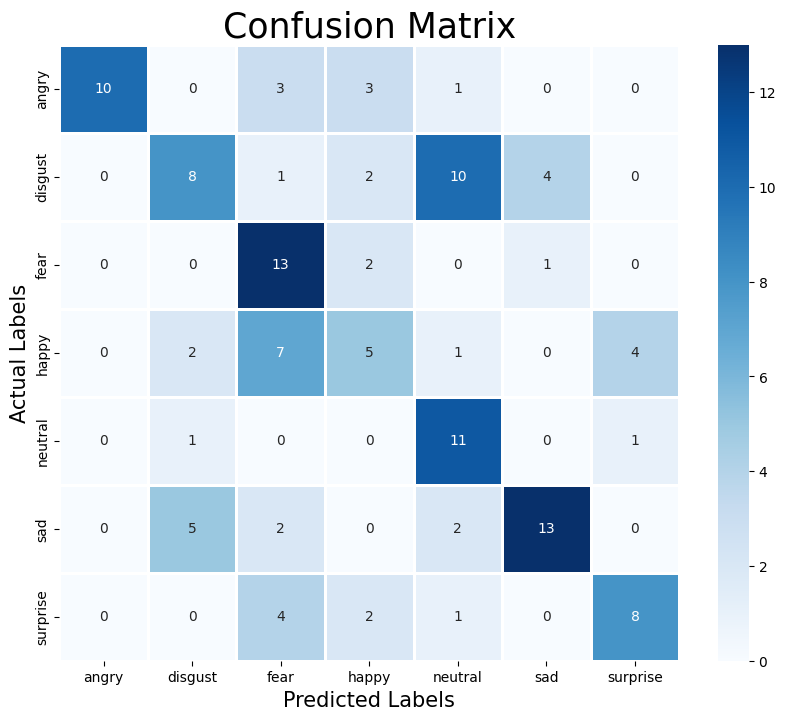

              precision    recall  f1-score   support

       angry       1.00      0.59      0.74        17
     disgust       0.50      0.32      0.39        25
        fear       0.43      0.81      0.57        16
       happy       0.36      0.26      0.30        19
     neutral       0.42      0.85      0.56        13
         sad       0.72      0.59      0.65        22
    surprise       0.62      0.53      0.57        15

    accuracy                           0.54       127
   macro avg       0.58      0.56      0.54       127
weighted avg       0.58      0.54      0.53       127



In [ ]:
model = cnn_for_ser_3()
run_model(model, x_train, y_train_ohe, x_val, y_val_ohe)
plot_confusion_matrix(model, x_test, y_test_ohe)

# With transfer learning

We decided to try a technique of transfer learning to mitigate the data scarcity problem, they main idea is to use other datasets like CreamaD and Ravdess to train the model, then fine tune the model on Emovo.

The first thing that we have to do is to repeat the preprocessing steps we have done on Emovo.

We have also decided to process the data in a different way: we split before the phrases into test and train set and only later we perform feature extraction, this we we can segment the audio making partially overlapping the windows, without the risk that one window will end in the train set and a partially overlapping window in the test set.
We let the windows overlap of half of their length, this way the number of windows we end up with is almost doubled.


## Preprocessing on other datasets

In [ ]:
X=Ravdess_df['Path'].tolist()+Crema_df['Path'].tolist()
Y=Ravdess_df['Emotions'].tolist()+Crema_df['Emotions'].tolist()

x_train_tr_, x_test_tr_, y_train_tr_, y_test_tr_ = train_test_split(X, Y, test_size= 0.2, random_state=0, shuffle=True)
x_test_tr_, x_val_tr_, y_test_tr_, y_val_tr_ = train_test_split(x_test_tr_, y_test_tr_, test_size= 0.5, random_state=0, shuffle=True)

x_test_tr = []
y_test_tr = []

x_train_tr = []
y_train_tr = []

x_val_tr = []
y_val_tr = []

In [ ]:
for i in range(len(x_train_tr_)):
    data, sr = librosa.load(x_train_tr_[i])

    start=0
    end=start+window_length*sr
    while end < len(data):
      feature=extract_feature(data[start:end], sr)
      if feature.shape == (160,):
        if y_train_tr_[i]!='calm':
          x_train_tr.append(feature)
          y_train_tr.append(y_train_tr_[i])
      start=int(start+window_length*sr/2)
      end=start+window_length*sr

with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/y_train_tr.pickle', "wb") as fp:
  pickle.dump(y_train_tr, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/x_train_tr.pickle', "wb") as fp:
  pickle.dump(x_train_tr, fp)

In [ ]:
for i in range(len(x_test_tr_)):
    data, sr = librosa.load(x_test_tr_[i])

    start=0
    end=start+window_length*sr
    while end < len(data):
      feature=extract_feature(data[start:end], sr)
      if feature.shape == (160,):
        if y_test_tr_[i]!='calm':
          x_test_tr.append(feature)
          y_test_tr.append(y_test_tr_[i])
      start=int(start+window_length*sr/2)
      end=start+window_length*sr

with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/y_test_tr.pickle', "wb") as fp:
  pickle.dump(y_test_tr, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/x_test_tr.pickle', "wb") as fp:
  pickle.dump(x_test_tr, fp)

In [ ]:
for i in range(len(x_val_tr_)):
    data, sr = librosa.load(x_val_tr_[i])

    start=0
    end=start+window_length*sr
    while end < len(data):
      feature=extract_feature(data[start:end], sr)
      if feature.shape == (160,):
        if y_val_tr_[i]!='calm':
          x_val_tr.append(feature)
          y_val_tr.append(y_val_tr_[i])
      start=int(start+window_length*sr/2)
      end=start+window_length*sr

with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/y_val_tr.pickle', "wb") as fp:
  pickle.dump(y_val_tr, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/x_val_tr.pickle', "wb") as fp:
  pickle.dump(x_val_tr, fp)

## Training and evaluation

Once we have preprocessed the other datasets we can start by training our model on them

In [ ]:
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/x_test_tr.pickle', "rb") as fp:
  x_test_tr = pickle.load(fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/x_train_tr.pickle', "rb") as fp:
  x_train_tr = pickle.load(fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/x_val_tr.pickle', "rb") as fp:
  x_val_tr = pickle.load(fp)

with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/y_test_tr.pickle', "rb") as fp:
  y_test_tr = pickle.load(fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/y_train_tr.pickle', "rb") as fp:
  y_train_tr = pickle.load(fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/y_val_tr.pickle', "rb") as fp:
  y_val_tr = pickle.load(fp)

In [ ]:
encoder = OneHotEncoder()
y_train_tr_ohe = encoder.fit_transform(np.array(y_train_tr).reshape(-1,1)).toarray()
y_test_tr_ohe = encoder.fit_transform(np.array(y_test_tr).reshape(-1,1)).toarray()
y_val_tr_ohe = encoder.fit_transform(np.array(y_val_tr).reshape(-1,1)).toarray()

x_train_tr = np.expand_dims(x_train_tr, axis=2)
x_test_tr = np.expand_dims(x_test_tr, axis=2)
x_val_tr = np.expand_dims(x_val_tr, axis=2)

Epoch 1/200
133/133 [==============================] - 4s 9ms/step - loss: 1.9026 - val_loss: 1.8549
Epoch 2/200
133/133 [==============================] - 1s 7ms/step - loss: 1.7978 - val_loss: 1.6763
Epoch 3/200
133/133 [==============================] - 1s 9ms/step - loss: 1.7126 - val_loss: 1.6693
Epoch 4/200
133/133 [==============================] - 1s 10ms/step - loss: 1.6687 - val_loss: 1.6726
Epoch 5/200
133/133 [==============================] - 1s 11ms/step - loss: 1.6455 - val_loss: 1.6039
Epoch 6/200
133/133 [==============================] - 1s 8ms/step - loss: 1.6303 - val_loss: 1.5902
Epoch 7/200
133/133 [==============================] - 1s 7ms/step - loss: 1.6222 - val_loss: 1.6006
Epoch 8/200
133/133 [==============================] - 1s 7ms/step - loss: 1.6028 - val_loss: 1.5689
Epoch 9/200
133/133 [==============================] - 1s 7ms/step - loss: 1.5709 - val_loss: 1.5553
Epoch 10/200
133/133 [==============================] - 1s 7ms/step - loss: 1.5545 - val_

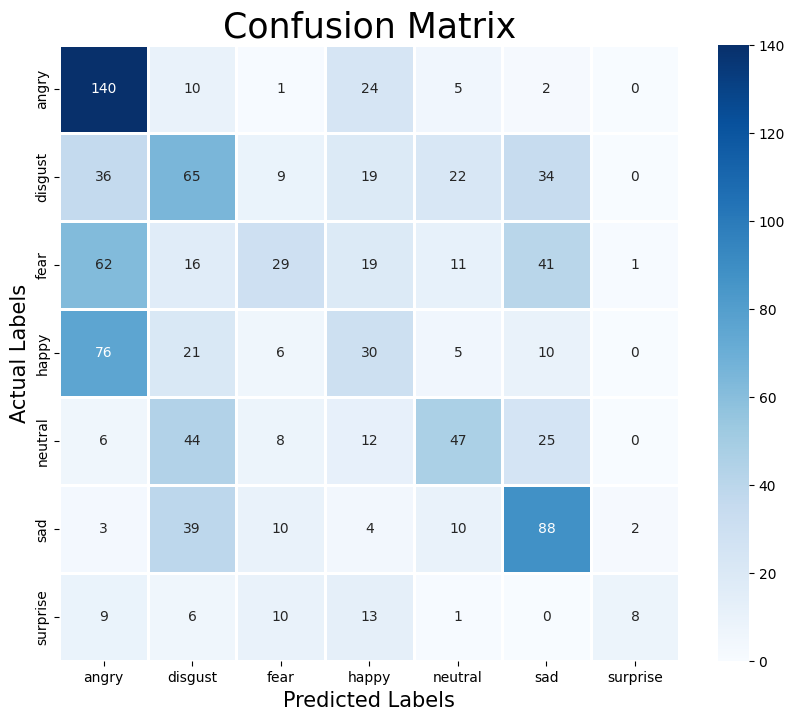

              precision    recall  f1-score   support

       angry       0.42      0.77      0.54       182
     disgust       0.32      0.35      0.34       185
        fear       0.40      0.16      0.23       179
       happy       0.25      0.20      0.22       148
     neutral       0.47      0.33      0.39       142
         sad       0.44      0.56      0.49       156
    surprise       0.73      0.17      0.28        47

    accuracy                           0.39      1039
   macro avg       0.43      0.36      0.36      1039
weighted avg       0.40      0.39      0.37      1039



In [ ]:
model=cnn_for_ser_3()
run_model(model, x_train_tr, y_train_tr_ohe, x_val_tr, y_val_tr_ohe)
plot_confusion_matrix(model, x_test_tr, y_test_tr_ohe)

In [ ]:
#code to save model weights
model.save_weights('drive/MyDrive/Project Human System Interfaces/dati_train_test/' + 'model_weights.h5')

As we can see the results are not so encouraging but this does not mean that the model haven't learned some good feature that can be usefull in a target domain.

## Evaluation on Emovo

Of course directly applying the model trained this way will lead into a terrible results since the source and target domain have some huge differences.

In [ ]:
model=cnn_for_ser_3()
model.load_weights('drive/MyDrive/Project Human System Interfaces/dati_train_test/' + 'model_weights.h5')

4/4 [==============================] - 0s 4ms/step


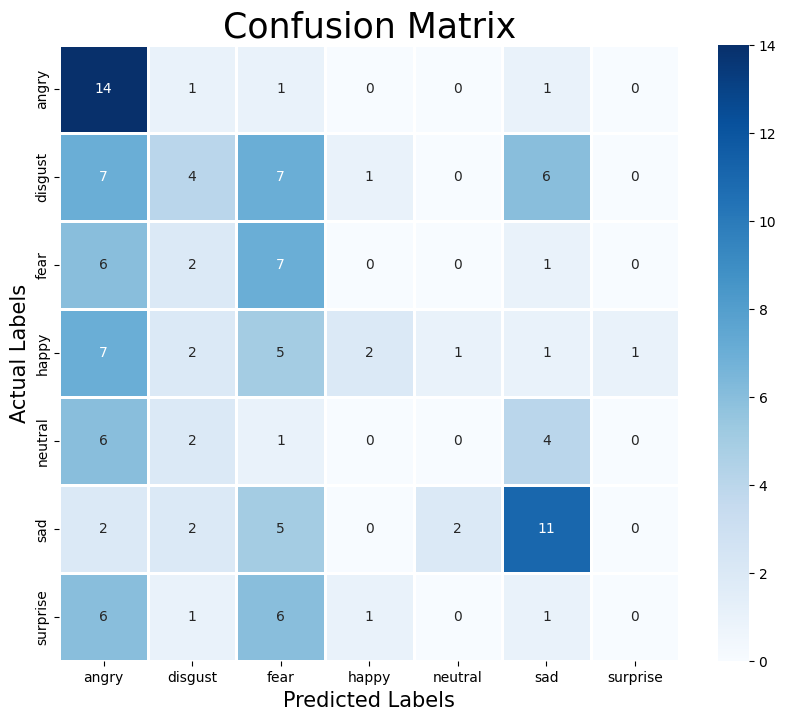

              precision    recall  f1-score   support

       angry       0.29      0.82      0.43        17
     disgust       0.29      0.16      0.21        25
        fear       0.22      0.44      0.29        16
       happy       0.50      0.11      0.17        19
     neutral       0.00      0.00      0.00        13
         sad       0.44      0.50      0.47        22
    surprise       0.00      0.00      0.00        15

    accuracy                           0.30       127
   macro avg       0.25      0.29      0.22       127
weighted avg       0.27      0.30      0.24       127



In [ ]:
plot_confusion_matrix(model, x_test, y_test_ohe)

## Fine tuning

Here we perform fine tuning freezing all the convolutional layers and letting only linear layers trainable

In [ ]:
n=len(model.layers)
for i in range(n):
  if i<11:
    model.layers[i].trainable=False
  else:
    model.layers[i].trainable=True
  print(model.layers[i].name, model.layers[i].trainable)

input_72 False
conv1d_355 False
max_pooling1d_355 False
conv1d_356 False
max_pooling1d_356 False
conv1d_357 False
max_pooling1d_357 False
conv1d_358 False
max_pooling1d_358 False
conv1d_359 False
max_pooling1d_359 False
flatten_71 True
dense_213 True
dropout_142 True
dense_214 True
dropout_143 True
dense_215 True


Epoch 1/200
7/7 [==============================] - 2s 46ms/step - loss: 0.9733 - val_loss: 1.6436
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 0.9819 - val_loss: 1.5488
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 0.9732 - val_loss: 1.5435
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.9400 - val_loss: 1.6693
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 0.9427 - val_loss: 1.5863
Epoch 6/200
7/7 [==============================] - 0s 10ms/step - loss: 0.9479 - val_loss: 1.4411
Epoch 7/200
7/7 [==============================] - 0s 11ms/step - loss: 0.9274 - val_loss: 1.4282
Epoch 8/200
7/7 [==============================] - 0s 9ms/step - loss: 0.9392 - val_loss: 1.4247
Epoch 9/200
7/7 [==============================] - 0s 14ms/step - loss: 0.9085 - val_loss: 1.5301
Epoch 10/200
7/7 [==============================] - 0s 10ms/step - loss: 0.9963 - val_loss: 1.5255
Epoch 11/200
7/7 [====

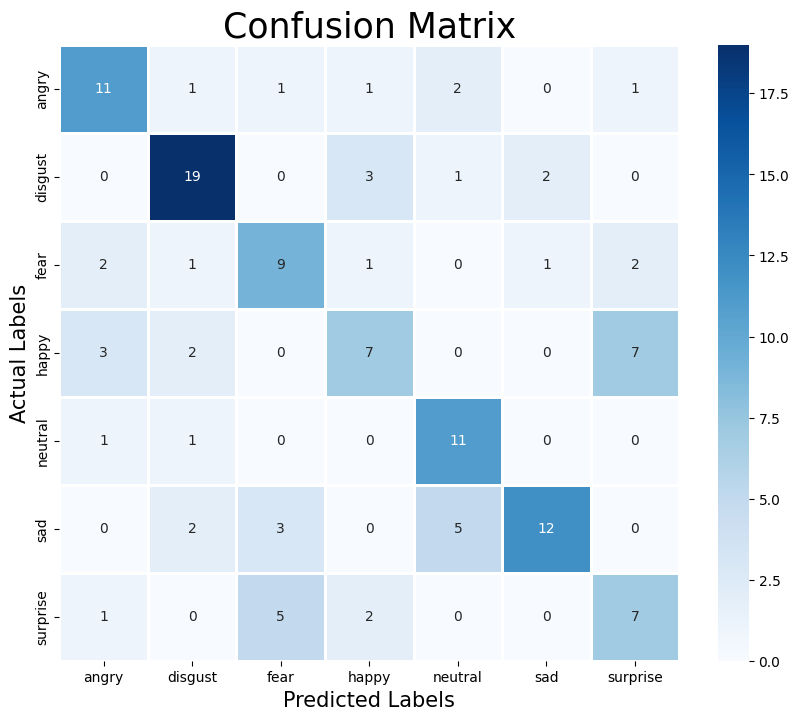

              precision    recall  f1-score   support

       angry       0.61      0.65      0.63        17
     disgust       0.73      0.76      0.75        25
        fear       0.50      0.56      0.53        16
       happy       0.50      0.37      0.42        19
     neutral       0.58      0.85      0.69        13
         sad       0.80      0.55      0.65        22
    surprise       0.41      0.47      0.44        15

    accuracy                           0.60       127
   macro avg       0.59      0.60      0.59       127
weighted avg       0.61      0.60      0.60       127



In [ ]:
run_model(model, x_train, y_train_ohe, x_val, y_val_ohe)
plot_confusion_matrix(model, x_test, y_test_ohe)

And as you can see the result are slightly better the the results obtained training the model from scratch using only Emovo.

Also this result looks like having a big variance: runnning the code multiple times may lead to very different results

# Using data Augmentation

In the end we want to train our model using the tecnique of data augmentation applied on Emovo. We have already discussed in the introduction how we are going to perform data augmentation.

Again we are going to perform the preprocessing in a different way: we want to avoid of two data coming from the same source (e.g. original audio and augmented audio) to be in different sets.
During feature extraction we want to keep track from which audio file the data came from to perform later on the split in a safe way.
Since we want to test other evaluation techniques we are also keeping track of the actor and the phrase it is saying.

## Functions for data augmentation

In [ ]:
def data_augment(data,sampling_rate):
  stretch_rate=0.85
  pitch_steps=0.5
  data_=[]
  data_.append(data)

  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data2 = data + noise_amp*np.random.normal(size=data.shape[0])
  data_.append(data2)

  data3=librosa.effects.time_stretch(y=data, rate=stretch_rate)
  data_.append(data3)

  data4=librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_steps)
  data_.append(data4)

  data5=librosa.effects.pitch_shift(y=data3, sr=sampling_rate, n_steps=pitch_steps)
  data_.append(data5)

  data6=librosa.effects.pitch_shift(y=data2, sr=sampling_rate, n_steps=pitch_steps)
  data_.append(data6)
  return data_

## Data augmentation and feature extraction

In [ ]:
#we have to split into train in test before data augmentation
X=Emovo_df['Path'].tolist()
Y=Emovo_df['Emotions'].tolist()
Z=Emovo_df['Actor'].tolist()
W=Emovo_df['Phrase'].tolist()

x_aug = [] #store the feature values
y_aug = [] #store the ground truth
a_aug = [] #store the actors
p_aug = [] #store the phrase
i_aug = [] #store the audio ID
aug = [] #store the information if the data is original or augmented

for i in range(len(X)):
    audio, sr = librosa.load(X[i])
    data_=data_augment(audio, sr)

    for j in range(len(data_)):
      data=data_[j]
      start=0
      end=start+window_length*sr
      while end < len(data):
        feature=extract_feature(data[start:end], sr)
        if feature.shape == (160,):
          x_aug.append(feature)
          y_aug.append(Y[i])
          a_aug.append(Z[i])
          p_aug.append(W[i])
          i_aug.append(i)
          if j==0:
            aug.append(0)
          else:
            aug.append(1)
        start=int(start+window_length*sr/2)
        end=start+window_length*sr

with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/y_aug.pickle', "wb") as fp:
  pickle.dump(y_aug, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/x_aug.pickle', "wb") as fp:
  pickle.dump(x_aug, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/a_aug.pickle', "wb") as fp:
  pickle.dump(a_aug, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/p_aug.pickle', "wb") as fp:
  pickle.dump(p_aug, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/i_aug.pickle', "wb") as fp:
  pickle.dump(i_aug, fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/aug.pickle', "wb") as fp:
  pickle.dump(aug, fp)

## Data splitting

We are going to split the data in 3 different ways

1) Naive split

2) Leave One Subject Out (LOSO)

3) Leave One Phrase Out

In 2 and 3 we also decided to use another phrase/actor for the validation set (e.g. in Loso we have 4 actors in the test set, 1 actor in train set and 1 actor in validation set)

In [ ]:
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/x_aug.pickle', "rb") as fp:
  x_aug = pickle.load(fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/y_aug.pickle', "rb") as fp:
  y_aug = pickle.load(fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/a_aug.pickle', "rb") as fp:
  a_aug = pickle.load(fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/p_aug.pickle', "rb") as fp:
  p_aug = pickle.load(fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/i_aug.pickle', "rb") as fp:
  i_aug = pickle.load(fp)
with open('drive/MyDrive/Project Human System Interfaces/dati_train_test/aug.pickle', "rb") as fp:
  aug = pickle.load(fp)

In [ ]:
#naive split
np.random.seed(3)
i_train_aug, i_test_aug = train_test_split(range(max(i_aug)), test_size= 0.25, random_state=0, shuffle=True)
i_test_aug, i_val_aug = train_test_split(i_test_aug, test_size= 0.4, random_state=0, shuffle=True)

x_train_aug= []
x_test_aug = []
x_val_aug  = []

y_train_aug= []
y_test_aug = []
y_val_aug  = []

idx_train_aug= []
idx_test_aug = []
idx_val_aug  = []

for i in range(len(i_aug)):
  if i_aug[i] in i_train_aug:
    x_train_aug.append(x_aug[i])
    y_train_aug.append(y_aug[i])
    idx_train_aug.append(i_aug[i])
  elif (i_aug[i] in i_test_aug):
    x_test_aug.append(x_aug[i])
    y_test_aug.append(y_aug[i])
    idx_test_aug.append(i_aug[i])
  elif i_aug[i] in i_val_aug:
    x_val_aug.append(x_aug[i])
    y_val_aug.append(y_aug[i])
    idx_val_aug.append(i_aug[i])

#leave one subject out
x_train_aug_2= []
x_test_aug_2 = []
x_val_aug_2 = []

y_train_aug_2= []
y_test_aug_2 = []
y_val_aug_2 = []

for i in range(len(a_aug)):
  if a_aug[i]=='m1':
    x_test_aug_2.append(x_aug[i])
    y_test_aug_2.append(y_aug[i])
  elif a_aug[i]=='f1':
    x_val_aug_2.append(x_aug[i])
    y_val_aug_2.append(y_aug[i])
  else:
    x_train_aug_2.append(x_aug[i])
    y_train_aug_2.append(y_aug[i])

#leave one phrase out
x_train_aug_3= []
x_test_aug_3 = []
x_val_aug_3 = []

y_train_aug_3= []
y_test_aug_3 = []
y_val_aug_3 = []

for i in range(len(a_aug)):
  if p_aug[i]=='l1':
    x_test_aug_3.append(x_aug[i])
    y_test_aug_3.append(y_aug[i])
  elif p_aug[i]=='l2':
    x_val_aug_3.append(x_aug[i])
    y_val_aug_3.append(y_aug[i])
  else:
    x_train_aug_3.append(x_aug[i])
    y_train_aug_3.append(y_aug[i])

In [ ]:
encoder = OneHotEncoder()
y_train_aug_ohe = encoder.fit_transform(np.array(y_train_aug).reshape(-1,1)).toarray()
y_test_aug_ohe = encoder.fit_transform(np.array(y_test_aug).reshape(-1,1)).toarray()
y_val_aug_ohe = encoder.fit_transform(np.array(y_val_aug).reshape(-1,1)).toarray()

x_train_aug = np.expand_dims(x_train_aug, axis=2)
x_test_aug = np.expand_dims(x_test_aug, axis=2)
x_val_aug = np.expand_dims(x_val_aug, axis=2)

y_train_aug_ohe_2 = encoder.fit_transform(np.array(y_train_aug_2).reshape(-1,1)).toarray()
y_test_aug_ohe_2 = encoder.fit_transform(np.array(y_test_aug_2).reshape(-1,1)).toarray()
y_val_aug_ohe_2 = encoder.fit_transform(np.array(y_val_aug_2).reshape(-1,1)).toarray()

x_train_aug_2 = np.expand_dims(x_train_aug_2, axis=2)
x_test_aug_2 = np.expand_dims(x_test_aug_2, axis=2)
x_val_aug_2 = np.expand_dims(x_val_aug_2, axis=2)

y_train_aug_ohe_3 = encoder.fit_transform(np.array(y_train_aug_3).reshape(-1,1)).toarray()
y_test_aug_ohe_3 = encoder.fit_transform(np.array(y_test_aug_3).reshape(-1,1)).toarray()
y_val_aug_ohe_3 = encoder.fit_transform(np.array(y_val_aug_3).reshape(-1,1)).toarray()

x_train_aug_3 = np.expand_dims(x_train_aug_3, axis=2)
x_test_aug_3 = np.expand_dims(x_test_aug_3, axis=2)
x_val_aug_3 = np.expand_dims(x_val_aug_3, axis=2)


## Training and evaluation

### Naive split

Epoch 1/200
74/74 [==============================] - 16s 18ms/step - loss: 1.9320 - val_loss: 1.8471
Epoch 2/200
74/74 [==============================] - 1s 8ms/step - loss: 1.8076 - val_loss: 1.6599
Epoch 3/200
74/74 [==============================] - 1s 10ms/step - loss: 1.6337 - val_loss: 1.5456
Epoch 4/200
74/74 [==============================] - 1s 11ms/step - loss: 1.3901 - val_loss: 1.7307
Epoch 5/200
74/74 [==============================] - 1s 11ms/step - loss: 1.1832 - val_loss: 1.3096
Epoch 6/200
74/74 [==============================] - 1s 12ms/step - loss: 1.0056 - val_loss: 1.4475
Epoch 7/200
74/74 [==============================] - 1s 11ms/step - loss: 0.9280 - val_loss: 1.5051
Epoch 8/200
74/74 [==============================] - 1s 10ms/step - loss: 0.7638 - val_loss: 1.2550
Epoch 9/200
74/74 [==============================] - 1s 8ms/step - loss: 0.6047 - val_loss: 1.3717
Epoch 10/200
74/74 [==============================] - 1s 8ms/step - loss: 0.5996 - val_loss: 1.3169
E

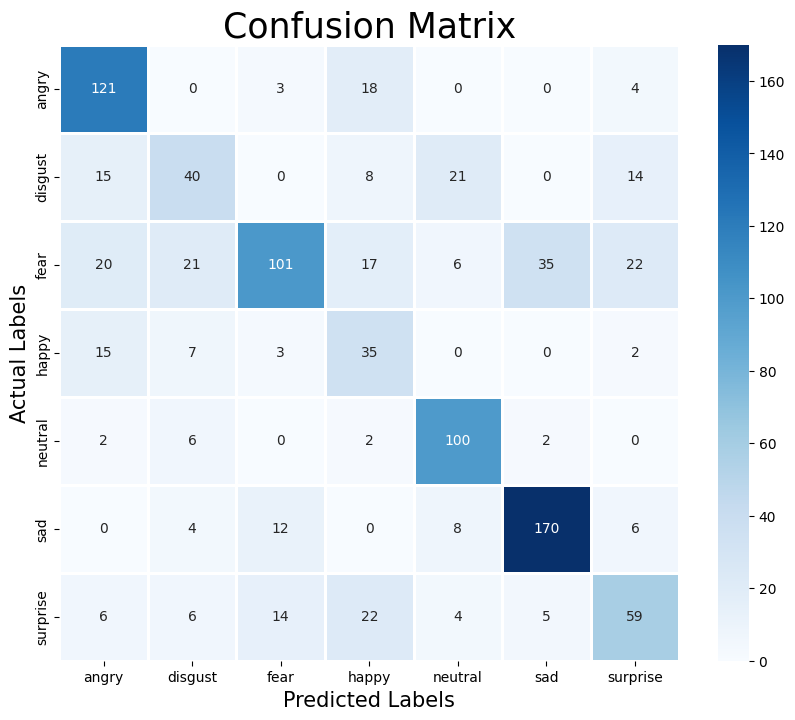

              precision    recall  f1-score   support

       angry       0.68      0.83      0.74       146
     disgust       0.48      0.41      0.44        98
        fear       0.76      0.45      0.57       222
       happy       0.34      0.56      0.43        62
     neutral       0.72      0.89      0.80       112
         sad       0.80      0.85      0.83       200
    surprise       0.55      0.51      0.53       116

    accuracy                           0.65       956
   macro avg       0.62      0.64      0.62       956
weighted avg       0.67      0.65      0.65       956



In [ ]:
model=cnn_for_ser_3()
run_model(model, x_train_aug, y_train_aug_ohe, x_val_aug, y_val_aug_ohe)
plot_confusion_matrix(model, x_test_aug, y_test_aug_ohe)

Results obtained with Naive split are slightly better than to the ones obtained with Fine tuning

### Leave one subject out

Epoch 1/200
63/63 [==============================] - 4s 17ms/step - loss: 1.8864 - val_loss: 2.2846
Epoch 2/200
63/63 [==============================] - 1s 11ms/step - loss: 1.5916 - val_loss: 3.1389
Epoch 3/200
63/63 [==============================] - 1s 12ms/step - loss: 1.3232 - val_loss: 2.7842
Epoch 4/200
63/63 [==============================] - 1s 12ms/step - loss: 1.0290 - val_loss: 4.3229
Epoch 5/200
63/63 [==============================] - 1s 12ms/step - loss: 0.8514 - val_loss: 3.5460
Epoch 6/200
63/63 [==============================] - 0s 8ms/step - loss: 0.6962 - val_loss: 3.5843
Epoch 7/200
63/63 [==============================] - 0s 8ms/step - loss: 0.6407 - val_loss: 4.4610
Epoch 8/200
63/63 [==============================] - 0s 8ms/step - loss: 0.4881 - val_loss: 3.7687
Epoch 9/200
63/63 [==============================] - 1s 8ms/step - loss: 0.4734 - val_loss: 3.7189
Epoch 10/200
63/63 [==============================] - 0s 8ms/step - loss: 0.4597 - val_loss: 4.2537
Epoc

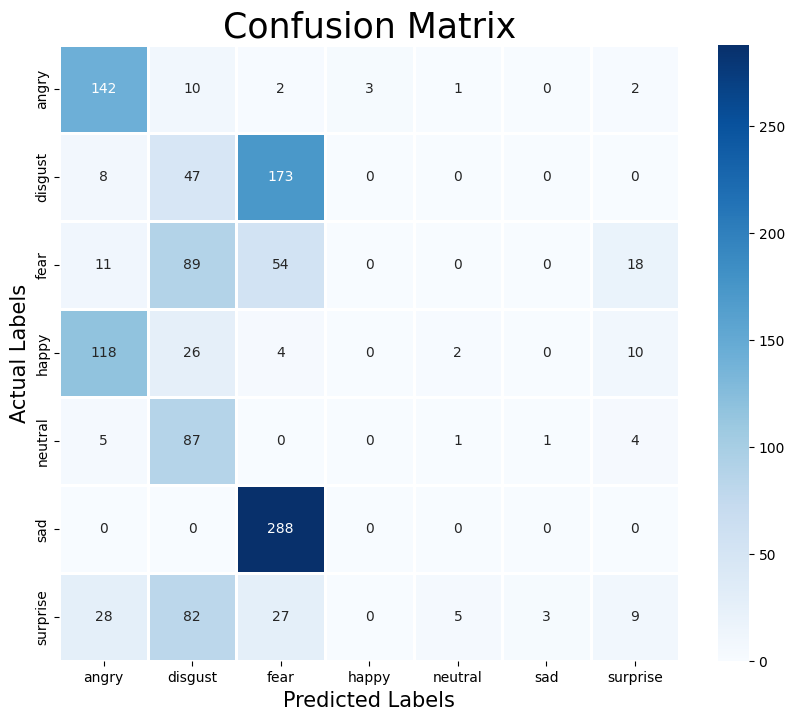

              precision    recall  f1-score   support

       angry       0.46      0.89      0.60       160
     disgust       0.14      0.21      0.17       228
        fear       0.10      0.31      0.15       172
       happy       0.00      0.00      0.00       160
     neutral       0.11      0.01      0.02        98
         sad       0.00      0.00      0.00       288
    surprise       0.21      0.06      0.09       154

    accuracy                           0.20      1260
   macro avg       0.14      0.21      0.15      1260
weighted avg       0.13      0.20      0.14      1260



In [ ]:
model=cnn_for_ser_3()
run_model(model, x_train_aug_2, y_train_aug_ohe_2, x_val_aug_2, y_val_aug_ohe_2)
plot_confusion_matrix(model, x_test_aug_2, y_test_aug_ohe_2)

Results obtained with LOSO are disappointing, this mean that if we want to use this model in a real life scenario we need to gather before a train set that include the person that we want to apply the model on.

In theory there are other solutions like gathering an italian Datasets with more than 6 actors to learn subject invariant features or collect unlabelled data from the final users and try some different transfer learning technique like domain adaptation.

We can also try using fine tuning using the model we have trained before since it was trained on a bigger dataset and probably have learned some subject-invariant feature.

Since we have more data to fine tune the model beacause of data augmentation we decided to leave one more layer to be trainable respect to the previous experiments.

In [ ]:
model=cnn_for_ser_3()
model.load_weights('drive/MyDrive/Project Human System Interfaces/dati_train_test/' + 'model_weights.h5')
n=len(model.layers)
for i in range(n):
  if i<9:
    model.layers[i].trainable=False
  else:
    model.layers[i].trainable=True
  print(model.layers[i].name, model.layers[i].trainable)

input_72 False
conv1d_355 False
max_pooling1d_355 False
conv1d_356 False
max_pooling1d_356 False
conv1d_357 False
max_pooling1d_357 False
conv1d_358 False
max_pooling1d_358 False
conv1d_359 True
max_pooling1d_359 True
flatten_71 True
dense_213 True
dropout_142 True
dense_214 True
dropout_143 True
dense_215 True


Epoch 1/200
63/63 [==============================] - 2s 10ms/step - loss: 1.9979 - val_loss: 1.8810
Epoch 2/200
63/63 [==============================] - 0s 6ms/step - loss: 1.5970 - val_loss: 2.5857
Epoch 3/200
63/63 [==============================] - 0s 6ms/step - loss: 1.4311 - val_loss: 2.3959
Epoch 4/200
63/63 [==============================] - 0s 6ms/step - loss: 1.2920 - val_loss: 2.8472
Epoch 5/200
63/63 [==============================] - 0s 6ms/step - loss: 1.2013 - val_loss: 2.9177
Epoch 6/200
63/63 [==============================] - 0s 6ms/step - loss: 1.0872 - val_loss: 3.5692
Epoch 7/200
63/63 [==============================] - 0s 6ms/step - loss: 1.0120 - val_loss: 3.8861
Epoch 8/200
63/63 [==============================] - 0s 6ms/step - loss: 0.9147 - val_loss: 3.0487
Epoch 9/200
63/63 [==============================] - 0s 6ms/step - loss: 0.8501 - val_loss: 3.6563
Epoch 10/200
63/63 [==============================] - 0s 6ms/step - loss: 0.7700 - val_loss: 3.7237
Epoch 11

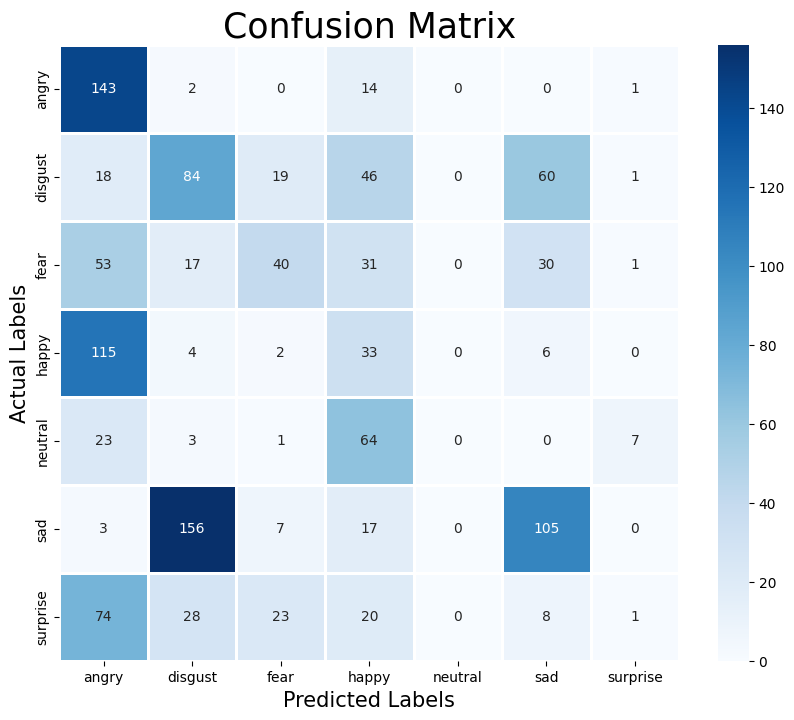

              precision    recall  f1-score   support

       angry       0.33      0.89      0.49       160
     disgust       0.29      0.37      0.32       228
        fear       0.43      0.23      0.30       172
       happy       0.15      0.21      0.17       160
     neutral       0.00      0.00      0.00        98
         sad       0.50      0.36      0.42       288
    surprise       0.09      0.01      0.01       154

    accuracy                           0.32      1260
   macro avg       0.26      0.30      0.25      1260
weighted avg       0.30      0.32      0.28      1260



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
run_model(model, x_train_aug_2, y_train_aug_ohe_2, x_val_aug_2, y_val_aug_ohe_2)
plot_confusion_matrix(model, x_test_aug_2, y_test_aug_ohe_2)

The result is still trash but in term of accuracy we got a significant change

### Leave one phrase out

Epoch 1/200
75/75 [==============================] - 4s 11ms/step - loss: 1.8149 - val_loss: 1.6552
Epoch 2/200
75/75 [==============================] - 1s 8ms/step - loss: 1.5477 - val_loss: 1.4300
Epoch 3/200
75/75 [==============================] - 1s 8ms/step - loss: 1.2398 - val_loss: 1.1299
Epoch 4/200
75/75 [==============================] - 1s 10ms/step - loss: 0.9989 - val_loss: 1.1235
Epoch 5/200
75/75 [==============================] - 1s 10ms/step - loss: 0.8491 - val_loss: 1.1806
Epoch 6/200
75/75 [==============================] - 1s 10ms/step - loss: 0.6763 - val_loss: 0.9261
Epoch 7/200
75/75 [==============================] - 1s 10ms/step - loss: 0.5847 - val_loss: 0.9975
Epoch 8/200
75/75 [==============================] - 1s 10ms/step - loss: 0.5306 - val_loss: 1.2013
Epoch 9/200
75/75 [==============================] - 1s 9ms/step - loss: 0.4613 - val_loss: 0.8830
Epoch 10/200
75/75 [==============================] - 1s 7ms/step - loss: 0.4536 - val_loss: 1.6360
Epo

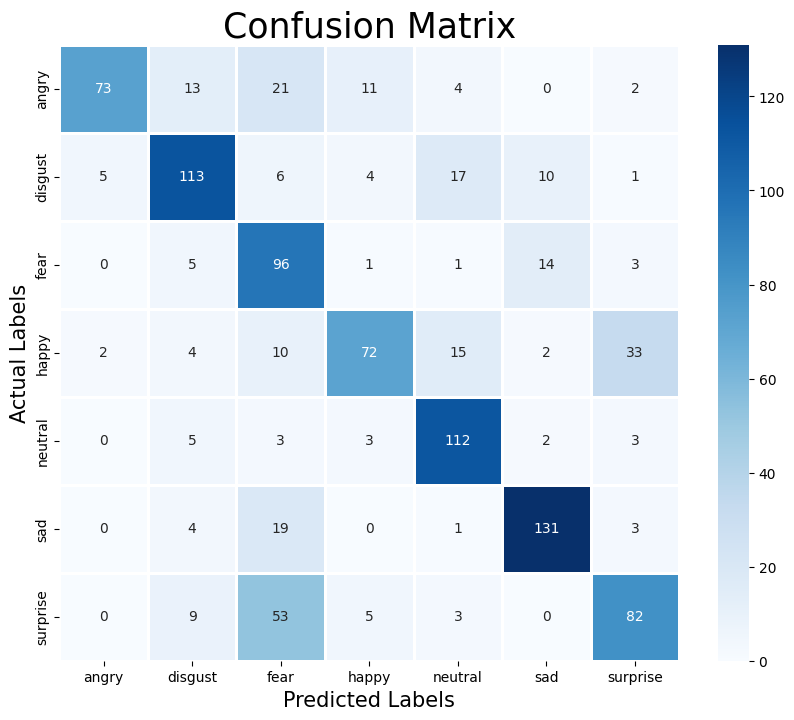

              precision    recall  f1-score   support

       angry       0.91      0.59      0.72       124
     disgust       0.74      0.72      0.73       156
        fear       0.46      0.80      0.59       120
       happy       0.75      0.52      0.62       138
     neutral       0.73      0.88      0.80       128
         sad       0.82      0.83      0.83       158
    surprise       0.65      0.54      0.59       152

    accuracy                           0.70       976
   macro avg       0.72      0.70      0.69       976
weighted avg       0.73      0.70      0.70       976



In [ ]:
model=cnn_for_ser_3()
run_model(model, x_train_aug_3, y_train_aug_ohe_3, x_val_aug_3, y_val_aug_ohe_3)
plot_confusion_matrix(model, x_test_aug_3, y_test_aug_ohe_3)

The result obtained leaving one phrase out are in line with the one obtained with a niave evaluation.

This mean that the model does not extract features that are specific to the phrases used for training.

Running the code multiple timeswe have noticed that LOPO sometimes perform even better results than the naive split, there are two possible reason for this:

-due to the structure of the dataset do the split this way will lead to equal distribution of classes in the train set, thing that does not necessarely happen with the random split

-we were lucky choosing a phrase that is well recognized by the network, maybe the network have more difficulties in analizing other typhe of phrases like short ones or non-sense ones